<a href="https://colab.research.google.com/github/tomonari-masada/course2021-stats1/blob/main/plot_gmm_covariances_(example).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 混合正規分布を使ったクラスタリング
* https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html

* このコードでは、クラスタの重心の初期化に、K-meansを手動で使う。
 * そのため、教師なし学習と言える。

* こうすると、GMMで得られたクラスタのインデックスと正解クラスのインデックスとの、対応づけが、失われる。
* そこで、この対応づけのためのコードも、追加する。

In [1]:
# Author: Ron Weiss <ronweiss@gmail.com>, Gael Varoquaux
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

# 乱数のシード
RANDOM_STATE = 0

%config InlineBackend.figure_formats = {'png', 'retina'}

* 共分散行列について、4種類の設定を試している。


1. クラスタごとに別々の共分散行列
2. 全てのクラスタで同じ共分散行列
3. クラスタごとに別々だが対角成分のみ非ゼロの共分散行列
4. クラスタごとに別々だが単位行列の定数倍の共分散行列



In [2]:
colors = ["navy", "turquoise", "darkorange"]

def make_ellipses(gmm, ax):
  for n, color in enumerate(colors):
    if gmm.covariance_type == "full":
      covariances = gmm.covariances_[n][:2, :2]
    elif gmm.covariance_type == "tied":
      covariances = gmm.covariances_[:2, :2]
    elif gmm.covariance_type == "diag":
      covariances = np.diag(gmm.covariances_[n][:2])
    elif gmm.covariance_type == "spherical":
      covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ell = mpl.patches.Ellipse(
        gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)
    ax.set_aspect("equal", "datalim")

* irisデータセットをクラスタリングする。
 * 25%をテストデータとして確保し、クラスタリングの結果を使って分類する。

In [3]:
iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(iris.data, iris.target)))


X_train = iris.data[train_index]
y_train = iris.target[train_index]
X_test = iris.data[test_index]
y_test = iris.target[test_index]

n_classes = len(np.unique(y_train))

* 4種類のモデルを辞書に保存しておく。

In [4]:
# Try GMMs using different types of covariances.
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20,
        random_state=RANDOM_STATE
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

* クラスタリングの結果を描画する。
 * 各クラスタの正規分布の密度関数の等高線を比べてみよう。

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


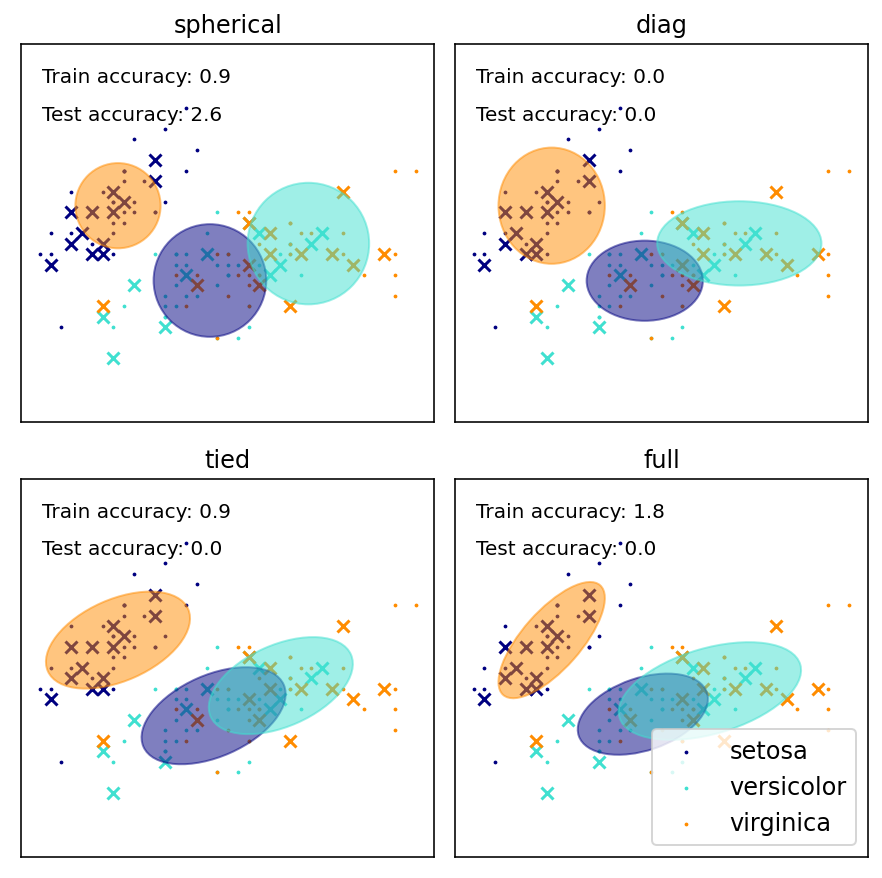

In [5]:
from sklearn.cluster import KMeans

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)

for index, (name, estimator) in enumerate(estimators.items()):

  # 手動でK-meansを実行し、その結果をGMMの初期化に使う
  kmeans = KMeans(n_clusters=n_classes, max_iter=1000,
                  random_state=RANDOM_STATE)
  y_train_pred = kmeans.fit_predict(X_train)
  estimator.means_init = np.array(
      [X_train[y_train_pred == i].mean(axis=0) for i in range(n_classes)]
  )
  
  estimator.fit(X_train)

  h = plt.subplot(2, n_estimators // 2, index + 1)
  make_ellipses(estimator, h)

  for n, color in enumerate(colors):
    data = iris.data[iris.target == n]
    plt.scatter(
        data[:, 0], data[:, 1], s=0.8, color=color, label=iris.target_names[n]
    )
  
  # Plot the test data with crosses
  for n, color in enumerate(colors):
    data = X_test[y_test == n]
    plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

  y_train_pred = estimator.predict(X_train)
  train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
  plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy, transform=h.transAxes)

  y_test_pred = estimator.predict(X_test)
  test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
  plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy, transform=h.transAxes)

  plt.xticks(())
  plt.yticks(())
  plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))


plt.show()

* このままでは、各クラスタのインデックスと、正確クラスのインデックスとの対応が、取れていない！
 * そのため、accuracyが、おかしな値になっている。
* そこで、各クラスタに対して、その重心が最も近い正解クラスを、対応づけしてみる。
 * その後で、改めて、test accuracyを計算する。

In [6]:
for index, (name, estimator) in enumerate(estimators.items()):
  print(name)

  y_test_pred = estimator.predict(X_test)

  # 各クラスタの重心から、真のクラスの重心のうち最も近いものを探して、対応づけをする。
  cluster2class = []
  for i in range(n_classes):
    # クラスタの重心の計算
    temp_mean = X_test[y_test_pred == i].mean()

    # 真のクラスの重心のうち、最も近いものを探す
    nearest_class = 0
    min_distance = np.linalg.norm(temp_mean - X_test[y_test == nearest_class].mean())
    for j in range(1, n_classes):
      temp_distance = np.linalg.norm(temp_mean - X_test[y_test == j].mean())
      if temp_distance < min_distance:
        min_distance = temp_distance
        nearest_class = j
    # 対応づけの表示
    print(f'\t\tcluster {i} -> true class {nearest_class}')
    cluster2class.append(nearest_class)

  # 上のセルと同様、test accuracyで評価
  y_test_pred = np.array([cluster2class[idx] for idx in y_test_pred])
  test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
  print(f'\tTest accuracy: {test_accuracy:.1f}')

spherical
		cluster 0 -> true class 1
		cluster 1 -> true class 2
		cluster 2 -> true class 0
	Test accuracy: 92.1
diag
		cluster 0 -> true class 1
		cluster 1 -> true class 2
		cluster 2 -> true class 0
	Test accuracy: 94.7
tied
		cluster 0 -> true class 1
		cluster 1 -> true class 2
		cluster 2 -> true class 0
	Test accuracy: 100.0
full
		cluster 0 -> true class 1
		cluster 1 -> true class 2
		cluster 2 -> true class 0
	Test accuracy: 100.0


* 注意：乱数のシードを変えると、評価結果がかなり変わることがある！
 * 最初のセルの`RANDOM_STATE`の値をいろいろ変えると、最後のTest accuracyがどう変わるか、調べてみよう。
 * "full"の場合のTest accuracyが大きく変動するはず。（"full"を採用しない理由になりうる。）